# Time dependent tensile response 

In [1]:
%matplotlib widget
import matplotlib.pylab as plt
from bmcs_beam.tension.time_dependent_cracking import TimeDependentCracking

In [2]:
import sympy as sp
sp.init_printing()
import numpy as np

# Single material point

## Time dependent function

In [3]:
TimeDependentCracking(T_prime_0 = 100).interact()

### Time-dependent temperature evolution function

Find a suitable continuous function that can represent the temperature evolution during the hydration. Currently the a function of a Weibull type has been chosen and transformed such that the peak value and the corresponding time can be specified as a parameter.

In [9]:
t = sp.symbols('t', nonnegative=True)

In [10]:
T_m = sp.Symbol("T_m", positive = True) 
T_s = sp.Symbol("T_s", positive = True) 

In [11]:
omega_fn = 1 - sp.exp(-(t/T_s)**T_m)

In [12]:
T_prime_0 = sp.Symbol("T_prime_0", positive = True)

In [13]:
T_t = (1 - omega_fn) * T_prime_0 * t

**Shape functions for temperature evolution**

In [14]:
T_t

In [15]:
T_prime_t = sp.simplify(T_t.diff(t))
T_prime_t

**Transform the shape function**
to be able to explicitly specify the maximum temperature and corresponding time 

In [16]:
t_argmax_T = sp.Symbol("t_argmax_T")
T_s_sol = sp.solve( sp.Eq( sp.solve(T_prime_t,t)[0], t_argmax_T ), T_s)[0]

In [17]:
T_max = sp.Symbol("T_max", positive=True)
T_prime_0_sol = sp.solve(sp.Eq(T_t.subs(T_s, T_s_sol).subs(t, t_argmax_T), T_max), 
                         T_prime_0)[0]

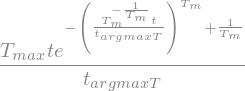

In [18]:
T_max_t = sp.simplify( T_t.subs({T_s: T_s_sol, T_prime_0: T_prime_0_sol}) )
T_max_t

In [19]:
get_T_t = sp.lambdify((t, T_prime_0, T_m, T_s), T_t)
get_T_max_t = sp.lambdify((t, T_max, t_argmax_T, T_m), T_max_t)
data = dict(T_prime_0=100, T_m=1, T_s=1)

In [21]:
_, ax = plt.subplots(1,1)
t_range = np.linspace(0,10,100)
plt.plot(t_range, get_T_t(t_range, **data));
plt.plot(t_range, get_T_max_t(t_range, 37, 1., 2));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Time dependent compressive strength

**From Eurocode 2:** 
$s$ captures the effect of cement type on the time evolution of the compressive strength
it ranges from $s = 0.2$ for class R (rapid), $s = 0.25$ for class N (normal), and $s = 0.38$ for class S (slow).

In [24]:
s = sp.Symbol("s", positive=True) 

In [25]:
beta_cc = sp.exp( s * (1 - sp.sqrt(28/t)))
beta_cc

In [26]:
get_beta_cc = sp.lambdify((t, s), beta_cc )

In [27]:
_, ax = plt.subplots(1,1)
plt.plot(t_range, get_beta_cc(t_range, 0.2))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<lambdifygenerated-17>:2: RuntimeWarning: divide by zero encountered in true_divide
  return (exp(s*(1 - 2*sqrt(7)/sqrt(t))))


### Compressive strength

In [28]:
f_cm_28 = sp.Symbol("f_cm28", positive=True)
f_cm_28

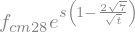

In [29]:
f_cm_t = beta_cc * f_cm_28
f_cm_t

In [30]:
get_f_cm_t = sp.lambdify((t, f_cm_28, s), f_cm_t)

### Tensile strength

In [31]:
f_ctm = sp.Symbol("f_ctm", positive=True)
alpha_f = sp.Symbol("alpha_f", positive=True)

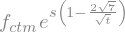

In [32]:
f_ctm_t = beta_cc * f_ctm
f_ctm_t

In [33]:
get_f_ctm_t = sp.lambdify((t, f_ctm, s), f_ctm_t)

### Elastic modulus

In [34]:
E_cm_28 = sp.Symbol("E_cm28", positive=True)

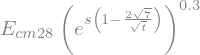

In [35]:
E_cm_t = (f_cm_t / f_cm_28)**0.3 * E_cm_28
E_cm_t

In [36]:
get_E_cm_t = sp.lambdify((t, E_cm_28, s), E_cm_t)

## Uncracked state

- Specimen is clamped at both sides. Then $\varepsilon_\mathrm{app} = 0, \forall x \in \Omega$

- Then the matrix stress is given as
\begin{align}
 \sigma^\mathrm{m}(x,t) = - E^\mathrm{m}(t) 
 \cdot \alpha \int_0^t T^\prime(x,\theta)\, \mathrm{d}\theta
\end{align}

In [40]:
alpha = sp.Symbol("alpha", positive=True )

In [44]:
eps_eff = alpha * T_max_t

In [53]:
dot_T_max_t = sp.simplify(T_max_t.diff(t))

In [65]:
dot_eps_eff = alpha * dot_T_max_t
dot_E_cm_t = E_cm_t.diff(t)

In [55]:
sig_t = E_cm_t * eps_eff

In [66]:
dot_sig_t = E_cm_t * dot_eps_eff + dot_E_cm_t * eps_eff

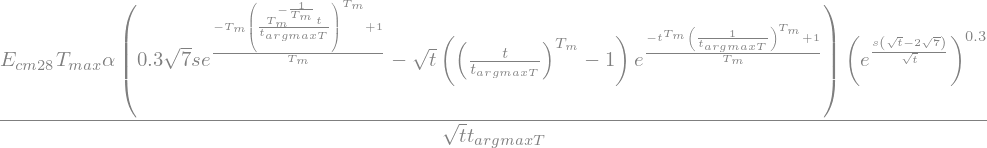

In [67]:
sp.simplify(dot_sig_t)

Integral cannot be resolved algebraically - numerical integration is used

In [64]:
#sig2_t = sp.integrate(dot_sig_t, (t,0,t))

# Single crack state

## Time-dependent debonding process

### Fibers

- If there is a crack at $x_I$, then there can be non-zero apparent strains within the debonded zone - measurable using local strain sensors, i.e. 
\begin{align}
\exists x \in (L_I^{(-)},L_I^{(+)}), \; \varepsilon_\mathrm{app}^\mathrm{f}(x,t) \neq 0.
\end{align}
- However, the integral of apparent strain in the fibers must disappear within the debonded zone, i.e. 
\begin{align}
\int_{L^{(-)}}^{L^{(+)}}\varepsilon^\mathrm{f}_\mathrm{app}(x,t)\, \mathrm{d}x = 0
\end{align}

- Crack bridging fiber stress is given as
\begin{align}
  \sigma^{\mathrm{f}}(x=0, t) = E^{\mathrm{f}} \varepsilon^{\mathrm{f}}_\mathrm{eff}(x=0, t) 
\end{align}

### Matrix

 - The integrated apparent strain in the matrix must be equal to crack opening $w_I$, i.e.
\begin{align}
\int_{L_I^{(-)}}^{L_I^{(+)}}\varepsilon^\mathrm{m}_\mathrm{app}(x,t)\, \mathrm{d}x + w_I = 0
\end{align}

- Considering symmetry, we can write
\begin{align}
\int_{0}^{L_I^{(+)}}\varepsilon^\mathrm{m}_\mathrm{app}(x,t)\, \mathrm{d}x 
+ \frac{1}{2} w_I(t) = 0
\end{align}

This relation holds for a homogeneous strain distribution along the bar specimen. 
Considering a non reinforced concrete bar, it is possible to detect the time of 
a crack occurrence by requiring setting:

\begin{align}
 f_\mathrm{ct}(t) = \sigma_\mathrm{c}(t)
\end{align}

# Multiple cracks

The temperature development during the hydration process follows the relation
\begin{align}
 T(t,x)
\end{align}

At the same time, the material parameters of the concrete matrix and of bond are 
defined as time functions
\begin{align}
 E(t), f_\mathrm{ct}(t), \tau(t)
\end{align}

Temperature-induced concrete strain in a point $x$ at time $t$ is expressed as
\begin{align}
\bar{\varepsilon}_{T}(t,x) = \alpha \int_0^t \frac{\mathrm{d} T(t,x)}{\mathrm{d} t} {\mathrm{d} t}
\end{align}

\begin{align}
\bar{\varepsilon}_\mathrm{app} = \bar{\varepsilon}_\mathrm{eff} + \bar{\varepsilon}_\mathrm{\Delta T}
\end{align}

If the apparent strain is suppressed, i.e. $\bar{\varepsilon}_\mathrm{app} = 0$, the effective stress is given as
\begin{align}
 0 = \bar{\varepsilon}_\mathrm{eff} + 
 \bar{\varepsilon}_{\Delta T} \implies 
 \bar{\varepsilon}_\mathrm{eff} = - \alpha \Delta T
\end{align}

More precisely, this equation reads
\begin{align}
\bar{\varepsilon}_\mathrm{eff}(t) = - \alpha \, \int_0^t \frac{\mathrm{d}T}{ \mathrm{d}t}  \, \mathrm{d} t
\end{align}

Current force at the boundary of the specimen is then given as
\begin{align}
\sigma = E(t) \, \varepsilon_{\mathrm{eff}}(t)
\end{align}

\begin{align}
\sigma = E(t) \left(\varepsilon_{\mathrm{app}}(x,t) - \alpha \int_0^t T^\prime(x,\theta) \, \mathrm{d}\theta \right) 
\end{align}

**Salient features of the algorithm**

Non-linearity included by cracking stress 

- find the time and location of the next crack occurrence
- provide a local, crack-centered solution of the cracking problem 